In [1]:
import numpy as np
import cv2
from PIL import Image,ImageSequence
import matplotlib.pyplot as plt
import tifffile as tiff
from tqdm import tqdm
from matplotlib.patches import Ellipse
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import random
import pims
import trackpy as tp
import os
from scipy import stats
from scipy.optimize import curve_fit

from helper_functions import *

In [7]:
folder = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration'
paths = find_tif(folder)
tifs = load(paths)
#


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:06<00:00, 337.46it/s]


In [52]:
def determine_needle_property(series,min_px=20,needle_with_um = 800,check=False):
    img = series[0]
    ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    inv = 255 - th2
    cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
    for cnt in cnts:
        if len(cnt) > min_px:
            print('minsize')
            contour = np.squeeze(cnt)
            polygon = Polygon(contour)
            x, y = polygon.exterior.xy
            x,y = np.array(x), np.array(y)
            #criteria for finding needle: countour has to contain at least one value smaller 250 and at least one == 0
            if (y < 250).any():# and (y == 0).any() or (y == 10).any():
                print('y')
                print(x,y)
                mask = y == 0
                x_ = x[mask]
                xl = np.min(x_)
                xr = np.max(x_)
                needle_with_px = (xr - xl)
                ej_x = xr - needle_with_px / 2
                ej_y = np.max(y)
                # get calibration: needle = 800 mikron
                # width of needle in px
                scaling_factor = needle_with_um*1e-6 / needle_with_px  # um/px
    if check == True:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(inv)
        ax.plot(ej_x, ej_y, marker="x", markersize=10,color='red')
        ax.annotate('', xy=(xl, 20), xycoords='data',xytext=(xr, 20), textcoords='data',
                     arrowprops={'arrowstyle': '<->', 'color': 'red'})
        plt.show()
    return needle_with_px, ej_x, ej_y, scaling_factor


# ugly helper to find all the ellipses and insert into one dataframe TODO rewrite it
def find_objects(list_of_series,list_of_configs,min_px=10,check=False):
    '''
    get list of np.arrays with data and config and return one big pandas dataframe with all the information
    :return:
    '''
    dic = {}
    files,n_cells,pressures,frs, xs, ys, ls, ss, angles, area_poly, perimeter_poly,widths,ej_xs,ej_ys,scaling_factors = [], [], [], [], [], [], [], [], [], [], [], [],[],[],[]
    for series,config in zip(list_of_series,list_of_configs):
        print(config['file'])
        width,ej_x,ej_y,scaling_factor = determine_needle_property(series,check=check)
        for i in range(len(series)):
            img = series[i]
            # thresholding, using automatic technique of Otsus thresholding
            ret2, th2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            # inverting the image
            inv = 255 - th2
            # find contours
            cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
            for cnt in cnts:
                if len(cnt) > min_px:
                    ellipse = cv2.fitEllipse(cnt)
                    x, y, l, s, p = ellipse[0][0], ellipse[0][1], ellipse[1][0], ellipse[1][1], ellipse[2]
                    files.append(config['file'])
                    n_cells.append(config['n_cells'])
                    pressures.append(config['pressure'])
                    widths.append(width)
                    ej_xs.append(ej_x)
                    ej_ys.append(ej_y)
                    scaling_factors.append(scaling_factor)
                    frs.append(i)
                    xs.append(x)
                    ys.append(y)
                    ls.append(l)
                    ss.append(s)
                    angles.append(p)
                    contour = np.squeeze(cnt)
                    polygon = Polygon(contour)
                    area_poly.append(polygon.area)
                    perimeter_poly.append(polygon.length)
        # save data into dictionary
        dic['file'] = files
        dic['n_cells'] = n_cells
        dic['pressure'] = pressures
        dic['width'] = widths
        dic['ej_x'] = ej_xs
        dic['ej_y'] = ej_ys
        dic['scaling_factor'] = scaling_factor
        dic['frame'] = frs
        dic['x'] = xs
        dic['y'] = ys
        dic['l'] = ls
        dic['s'] = ss
        dic['angle'] = angles
        dic['area_poly'] = area_poly
        dic['perimeter_poly'] = perimeter_poly

    df = pd.DataFrame(dic)
    return df


\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_19_12_05_36.tif
minsize
y
[168. 168. 169. 169. 170. 170. 171. 170. 171. 171. 172. 172. 173. 173.
 174. 174. 175. 175. 176. 176. 177. 177. 178. 178. 179. 179. 182. 182.
 184. 184. 186. 187. 189. 190. 205. 206. 213. 214. 215. 216. 217. 261.
 262. 274. 275. 276. 284. 285. 286. 287. 288. 289. 289. 290. 290. 291.
 291. 292. 292. 293. 293. 294. 294. 296. 296. 297. 297. 298. 298. 299.
 299. 300. 300. 299. 299. 300. 299. 299. 298. 298. 168.] [ 0. 20. 21. 39. 40. 52. 53. 54. 55. 61. 62. 65. 66. 69. 70. 72. 73. 75.
 76. 77. 78. 79. 80. 81. 82. 83. 86. 87. 89. 90. 90. 91. 91. 92. 92. 93.
 93. 94. 93. 93. 94. 94. 95. 95. 94. 95. 95. 94. 95. 94. 94. 93. 92. 91.
 90. 89. 88. 87. 86. 85. 84. 83. 82. 80. 78. 77. 76. 75. 71. 70. 60. 59.
 42. 41. 40. 39. 38.  5.  4.  0.  0.]


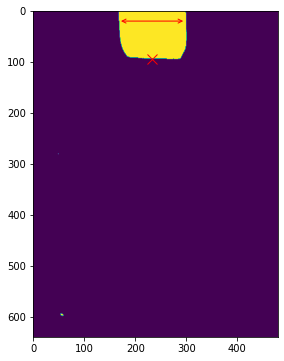

\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_19_12_07_10.tif
minsize
minsize
minsize
y
[470. 469. 467. 465. 464. 460. 460. 459. 459. 458. 458. 460. 460. 461.
 461. 462. 463. 465. 466. 467. 468. 469. 477. 478. 479. 479. 476. 475.
 470.] [ 0.  1.  1.  3.  3.  7.  8.  9. 10. 11. 21. 23. 24. 25. 26. 27. 27. 29.
 29. 30. 30. 31. 31. 30. 30.  1.  1.  0.  0.]
minsize
y
[164. 164. 165. 165. 166. 165. 165. 166. 166. 167. 167. 168. 168. 169.
 169. 170. 170. 171. 171. 172. 172. 173. 173. 174. 174. 175. 175. 178.
 178. 182. 184. 185. 198. 199. 207. 208. 255. 256. 261. 262. 263. 264.
 283. 286. 286. 287. 287. 289. 289. 290. 290. 291. 291. 292. 292. 293.
 293. 294. 294. 295. 295. 296. 296. 295. 295. 296. 295. 295. 294. 295.
 294. 294. 164.] [ 0.  8.  9. 38. 39. 40. 41. 42. 55. 56. 62. 63. 67. 68. 72. 73. 75. 76.
 78. 79. 80. 81. 82. 83. 84. 85. 86. 89. 90. 94. 94. 95. 95. 96. 96. 97.
 97. 98. 98. 99. 99. 98. 98. 95. 93. 92. 91. 89. 88. 87. 86. 85. 84. 83.
 82. 81. 79. 7

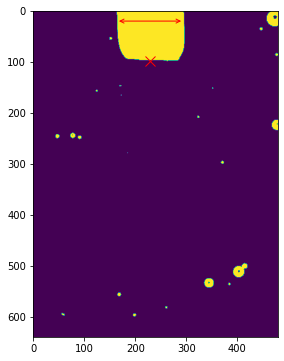

\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_19_12_07_33.tif
minsize
minsize
minsize
minsize
y
[165. 165. 166. 166. 167. 167. 168. 168. 169. 169. 170. 170. 171. 171.
 172. 172. 173. 173. 174. 174. 175. 175. 176. 176. 180. 180. 181. 182.
 183. 186. 187. 203. 204. 210. 211. 212. 213. 257. 258. 282. 283. 285.
 285. 286. 286. 287. 287. 288. 288. 289. 289. 290. 290. 291. 291. 292.
 292. 293. 293. 294. 294. 295. 295. 296. 296. 295. 295. 165.] [  0.  31.  32.  56.  57.  64.  65.  69.  70.  73.  74.  77.  78.  80.
  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  94.  95.  96.  96.
  97.  97.  98.  98.  99.  99. 100.  99. 100. 100. 101. 101. 100. 100.
  99.  98.  97.  96.  95.  94.  93.  92.  91.  90.  89.  88.  87.  86.
  85.  84.  83.  82.  80.  79.  74.  73.  21.  20.   0.   0.]


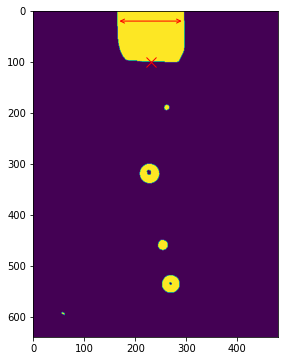

\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_25_12_34_14.tif
minsize
minsize
minsize
minsize
minsize
y
[35. 35. 34. 32. 30. 30. 29. 29. 28. 29. 29. 30. 30. 33. 33. 33. 34. 35.
 36. 40. 44. 44. 45. 45. 44. 44. 43. 41. 40. 39. 36. 35.] [241. 242. 243. 243. 245. 246. 247. 248. 249. 250. 253. 254. 255. 258.
 259. 258. 257. 257. 258. 258. 254. 253. 252. 248. 247. 245. 245. 243.
 243. 242. 242. 241.]


ValueError: zero-size array to reduction operation minimum which has no identity

In [53]:
configs = get_config(paths)
df = find_objects(tifs,configs,min_px=80,check=True)
df = add_properties(df)
df = filter_objects(df)
traj = link(df)

In [ ]:
plot_traj(traj,tifs,configs)
#traj = filter_trajectories(traj,tifs,configs)
#plot_traj(traj,tifs,configs)

In [40]:
#choose tiff file 

path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_38_10.tif' #lot of bubbles 100pa
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\2000\2022_06_24_13_03_41.tif' #two single bubles, one spheroid
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_36_20.tif' #debris output
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\2000\2022_06_24_13_05_18.tif' #only one spheroid
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_30_40.tif'
#path_to_tif = r'‪\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\500\2022_06_24_16_36_08.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\500\2022_06_24_16_06_14.tif' #lot of bubbles2, 80pa
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\24_06_22\250\2022_06_24_15_43_52.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\new_camera\2022_07_01_15_55_32.tif' #only one spheroid new camera
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\01_07_22\1000_cell\2022_07_01_16_40_51.tif'
#path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\01_07_22\1000_cell\2022_07_01_16_45_55.tif'
path_to_tif = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\calibration\50kPa\2022_07_25_12_34_23.tif'
#create path to output video
head, tail = os.path.split(path_to_tif)
output_path = os.path.join(r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data',tail[:-3]+'mp4')
print(output_path)

\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\2022_07_25_12_34_23.mp4


# load the tif file

In [41]:
def load_tif(path):
    with tiff.TiffFile(path) as tif:
        series = [page.asarray() for page in tqdm(tif.pages[0:])]
        series = np.array(series)
        series = series.astype(np.uint8)
        series = cv2.normalize(series, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)
    return series

series = load_tif(path_to_tif)
#normalize images to 8bit range[0,255] compatible with opencv
#
print(series.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2244/2244 [00:06<00:00, 350.50it/s]


(2244, 640, 480)


# Extract ellipses

1909
Otsus threshold 57.0


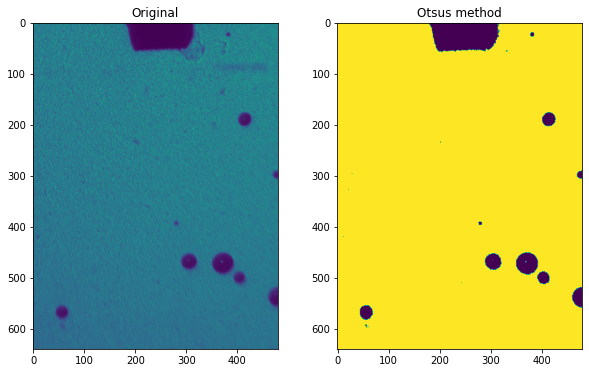

In [42]:
#choose random image from series
n = random.randint(0, len(series))
#n = 934
print(n)
img = series[n]

fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(10,6))
axs[0].set_title('Original')
axs[0].imshow(img)

#normal thresholding on manually set threshold t=40
th, threshed = cv2.threshold(img, 50, 255, cv2.THRESH_BINARY)

#axs[1].set_title('manual thres.')
#axs[1].imshow(threshed)
#adaptively chosen threshold by Otsu's method
ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('Otsus threshold',ret2)
axs[1].set_title('Otsus method')
axs[1].imshow(th2)

plt.show()



Text(0.5, 1.0, 'Triangle')

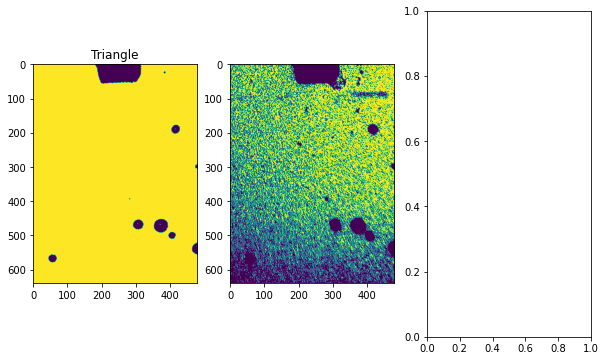

In [43]:
from skimage import data
from skimage import filters
from skimage.filters.thresholding import _cross_entropy
from skimage.filters import threshold_triangle

#try different thresholding techniques
img = series[n]
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(10,6))
axs[0].set_title('Li')

thresholds = np.arange(np.min(img) + 1.5, np.max(img) - 1.5)
entropies = [_cross_entropy(img, t) for t in thresholds]

optimal_img_threshold = thresholds[np.argmin(entropies)]

axs[0].imshow(img>optimal_img_threshold)


th_triangle = threshold_triangle(img, nbins = 50)
axs[1].imshow(img>th_triangle)
axs[0].set_title('Triangle')

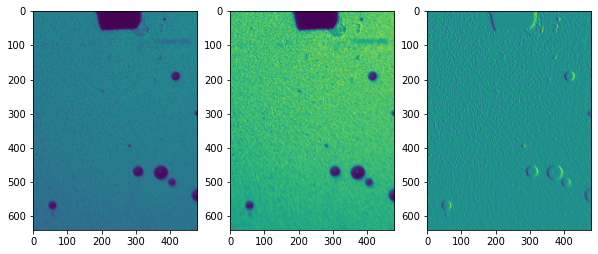

In [44]:
#try segmentation with canny-edge (work in progress)
fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(10,6))
axs[0].imshow(img)
img_blur = cv2.GaussianBlur(img, (3,3), 0)
axs[1].imshow(img_blur)
def auto_canny(image, sigma=0.33):
        # compute the median of the single channel pixel intensities
        v = np.median(image)
        # apply automatic Canny edge detection using the computed median
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        edged = cv2.Canny(image, lower, upper)
        # return the edged image
        return edged
    
#edges = cv2.Canny(image=img_blur, threshold1=225, threshold2=250)
edges = auto_canny(img,sigma=0.4)
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge D
sobelx = cv2.normalize(sobelx, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)#
#axs[2].imshow(edges)
axs[2].imshow(sobelx)

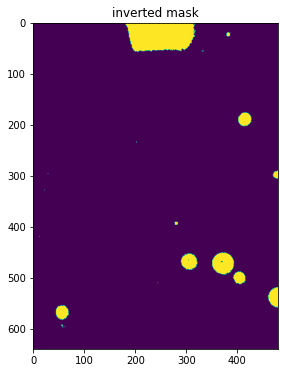

In [45]:
#invert the image and find contours
inv = 255 - th2
fig,ax=plt.subplots(figsize=(10,6))
ax.imshow(inv)
ax.set_title('inverted mask')

plt.show()  



139
width 132.0
247.0 58.0


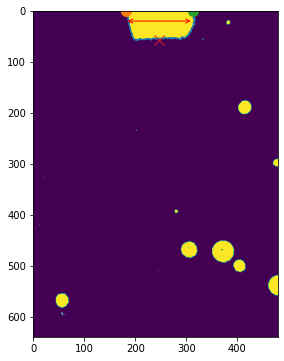

In [46]:
#get calibration: needle = 800mikron
#width of needle in px
w_needle_px = np.sum(inv[0,:] == 255)
print(w_needle_px)
factor = 800e-6/w_needle_px #um/px

fig,ax=plt.subplots(figsize=(10,6))
ax.imshow(inv)

cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
for cnt in cnts:
    if len(cnt) > 80:
        contour = np.squeeze(cnt)
        polygon = Polygon(contour)
        x,y = polygon.exterior.xy
        y = np.array(y)
        x = np.array(x)
        if (y < 250).any() and (y == 0).any():
            ax.plot(x,y)
            mask = y == 0
            x_ = x[mask]
            xl = np.min(x_)
            ax.plot(xl, 0, marker="o", markersize=10)
            xr = np.max(x_)
            ax.plot(xr, 0, marker="o", markersize=10)
            width = (xr - xl)
            print('width',width)
            ej_x = xr - width/2
            ej_y = np.max(y)
            
ax.plot(ej_x, ej_y, marker="x", markersize=10)
ax.annotate(
    '', xy=(xl, 20), xycoords='data',
    xytext=(xr, 20), textcoords='data',
    arrowprops={'arrowstyle': '<->','color':'red'})
print(ej_x,ej_y)

12.930252075195312 1709.1077880859375 184.91119384765625 225.7659912109375 106.12284851074219
533.5164184570312 117.34796905517578 345.2152404785156 577.7644653320312 90.49848175048828
18777.5


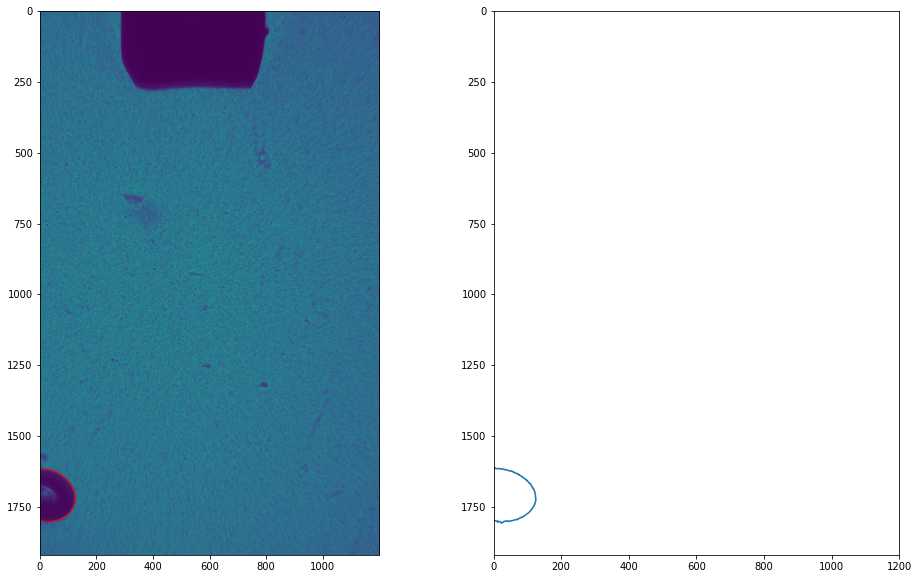

In [24]:
#using opencv to find contours of binary masks
'''
setting filters:
    - contour has to consist of minimum amount of pixel to fitler debris: min_px
    - fit ellipse to contour: ellipse has to have a min length: min_l
    - ellipse y coordinate has to be higher than output of needle tip: min_y
'''
min_px = 80
min_l = 20
min_y = 250

cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]

ells = []
for cnt in cnts:
    if len(cnt) > min_px:
        ellipse = cv2.fitEllipse(cnt)
        x,y,l,s,p = ellipse[0][0],ellipse[0][1],ellipse[1][0],ellipse[1][1],ellipse[2]
        print(x,y,l,s,p)
        if l > min_l and y > min_y:
            ells.append([x,y,l,s,p])
            
fig,axs = plt.subplots(figsize=(16,10),ncols=2)

axs[0].imshow(img)
for e in ells:
    e = Ellipse(xy=(e[0],e[1]),width=e[2], height=e[3],angle=e[4])
    axs[0].add_artist(e)
    e.set_clip_box(axs[0].bbox)
    e.set_facecolor("none")
    e.set_edgecolor("red")

from shapely.geometry import Polygon
for cnt in cnts:
    if len(cnt) > min_px:
        contour = np.squeeze(cnt)
        polygon = Polygon(contour)
        x,y = polygon.exterior.xy
        if (np.array(y)>100).all():
            axs[1].plot(x,y)
            print(polygon.area)
axs[1].set_xlim(0,img.shape[1])
axs[1].set_ylim(img.shape[0],0)
plt.show()

# using trackpy to find trajectories

In [25]:
def find_objs(series):
    dic = {}
    frs,xs,ys,ls,ss,angles,area_poly,perimeter_poly = [],[],[],[],[],[],[],[]
    #loop over all images in series and extract ellipses
    for i in range(len(series)):
        img = series[i]
        #thresholding
        ret2,th2 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #inverting
        inv = 255 - th2
        #find contours
        cnts, hiers = cv2.findContours(inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        for cnt in cnts:
            if len(cnt) > min_px:
                ellipse = cv2.fitEllipse(cnt)
                x,y,l,s,p = ellipse[0][0],ellipse[0][1],ellipse[1][0],ellipse[1][1],ellipse[2]
                if l > min_l and y > min_y:
                    frs.append(i)
                    xs.append(x)
                    ys.append(y)
                    ls.append(l)
                    ss.append(s)
                    angles.append(p)
                    
                    contour = np.squeeze(cnt) 
                    polygon = Polygon(contour)
                    area_poly.append(polygon.area)
                    perimeter_poly.append(polygon.length)
                    
    #save data into dictionary
    dic['frame'] = frs
    dic['x'] = xs
    dic['y'] = ys
    dic['l'] = ls
    dic['s'] = ss
    dic['angle'] = angles
    dic['area_poly'] = area_poly
    dic['perimeter_poly'] =perimeter_poly 
    df = pd.DataFrame(dic)
    return df

In [26]:
df = find_objs(series)

In [37]:
#find trajectories: tp.link adds column "particle" to df
'''
set parameters for trajectories
    - max_px: the maximum distance features can move between frames, optionally per dimension
    - memory: the maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle. 0 by default.
'''

def link(df,max_px = 300,memory = 0):
    traj = tp.link(df, max_px, memory=memory,pos_columns=['area_poly','y','x'])
    return traj

traj = link(df)
traj.head()

Frame 449: 1 trajectories present.


,frame,x,y,l,s,angle,area_poly,perimeter_poly,particle
0,0,346.409912,1805.080566,38.495991,40.808594,167.595642,1209.5,147.781746,0
1,0,960.140259,1686.131714,53.955593,55.538719,163.219055,2327.0,196.651804,1
2,1,959.929199,1686.082520,53.808884,55.957359,150.979965,2335.5,206.208153,1
3,2,960.015381,1686.304932,53.834862,55.574333,149.419205,2319.0,204.308658,1
4,3,346.083862,1805.571777,38.709953,40.650139,179.603134,1214.0,150.024387,2


In [38]:
#define functions to calculate area, strain, deformation of ellipses

def area_ell(l,s):
    return np.pi * l  * s * 0.25

def perimeter_ell(l,s):
    a = l/2
    b = s/2
    return np.pi*(3*((a+b)/2)-np.sqrt(a*b))

def guck_deform(area,perimeter):
    c = 2*np.sqrt(np.pi*area)/perimeter
    d = 1-c
    return d

def strain(l,s):
    a = l/2
    b = s/2
    return (np.abs(a - b)) / np.sqrt(a * b)

#add traveled distance
def euclidean_dist(x1,y1,x2,y2):
    return np.sqrt((x1-x2)**2 + (y1-y2)**2)

In [39]:
#find ejection point (#TODO), right now set manually
ej_point = (470,250)

def add_properties(traj):

    #add properties to pandas data frame
    traj['guck_def'] = guck_deform(area_ell(traj['l'],traj['s']),perimeter_ell(traj['l'],traj['s']))
    traj['guck_poly'] = guck_deform(traj['area_poly'],traj['perimeter_poly'])
    traj['strain'] = strain(traj['l'],traj['s'])
    traj['area_el'] = area_ell(traj['l'],traj['s'])
    traj['radius'] = np.sqrt(traj['area_el']/np.pi)
    
    #add properties in meter
    traj['radius_m'] = factor*traj['radius']
    traj['l_m'] = factor*traj['l']
    traj['s_m'] = factor*traj['s']
    traj['area_el_m'] = area_ell(traj['l_m'],traj['s_m'])
    
    #add traveled distance (in meter)
    traj['traveled_dist'] = euclidean_dist(traj['x'],traj['y'],ej_point[0],ej_point[1])
    traj['traveled_dist_m'] = factor*traj['traveled_dist'] 
    return traj
traj = add_properties(traj)

(1920, 1200)


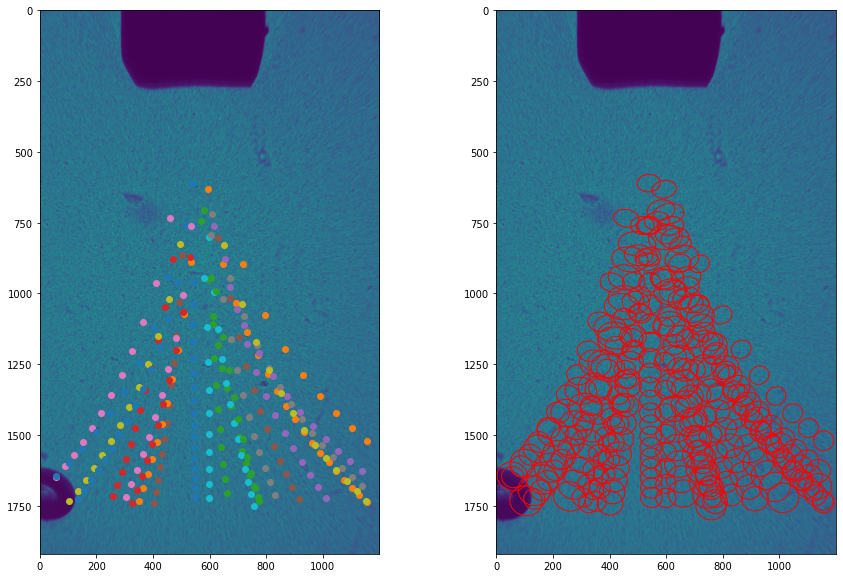

In [40]:
#filter trajectories

def filter_traj(traj,min_det=3,y0_min=250,y0_max=1000,y_last=1500,area_tol=0.5,y_max=1750,area_max=12000):
    '''
    min_det: minimum detections to count as trajectory
    y0_min/ y0_max: first detection has to be in this range
    #area_tol: area of detected object should not change more than tolarance 
    y_last hast to be higher than this value
    y_max: cut everthing off right before image ends
    '''

    #filter df that only reasonable tracks are in it
    remove = []
    remove_ind = []
    group = traj.groupby('particle')
    median_r = np.median(np.sqrt(traj['area_el']/np.pi))
    
    traj = traj[traj['y'] < y_max]

    for particle,g in group:
    
        #paticle should have at least min_det detections in trajectory, y-coord of first detection should be higher than y_0 and smaller than y0_max
        #last detection should be higher than 1500px to filter trajectories leaving image immediately
        if len(g) < min_det or g['y'].iloc[0] < y0_min or g['y'].iloc[0] > y0_max or g['y'].iloc[-1] < y_last:
            remove.append(particle)
        mode = float(stats.mode(g['area_poly'])[0])
        #area should not be bigger than 12000 px and area shouldnt change drasticly over time
        if (g['area_poly']>area_max).any() or (g['area_el'] < mode*(1-area_tol)).any() or (g['area_el'] > mode*(1+area_tol)).any():
            remove.append(particle)
        #bubble should not travel backwards
        if (g['traveled_dist'].sort_values(ascending=True).reset_index(drop=True) != g['traveled_dist'].reset_index(drop=True)).any():
            remove.append(particle)

    
    for r in remove:
        traj = traj.drop(traj[traj.particle == r].index)
    
    n_par = np.unique(traj['particle'])
    


    return traj

traj = filter_traj(traj)
traj = traj[traj['particle']!=15]
fig,axs = plt.subplots(figsize=(15,10),nrows=1,ncols=2)

print(series[n].shape)
axs[0].imshow(series[n])

for par,d in traj.groupby('particle'):
    axs[0].scatter(d['x'],d['y'])    

axs[1].imshow(series[n])
m = traj['frame'] == n
ells = traj[m]
for index, row in traj.iterrows():
    e = Ellipse(xy=(row['x'],row['y']),width=row['l'], height=row['s'],angle=row['angle'])
    axs[1].add_artist(e)
    e.set_facecolor("none")
    e.set_edgecolor("red")
plt.show()


[1.16287685e-02 9.46315014e+02 1.52433019e+00]


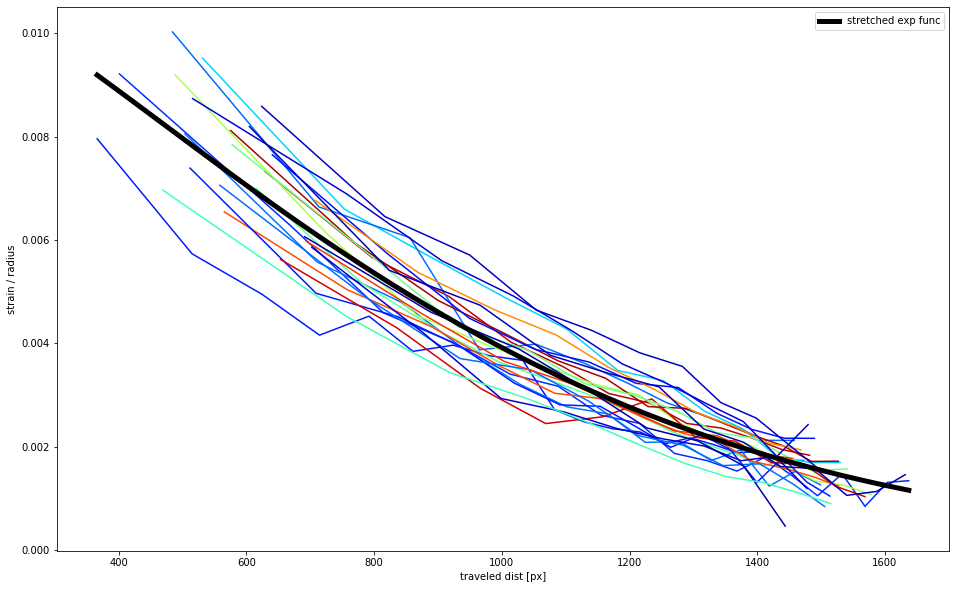

In [41]:
def linear(x,m,t):
    return x*m+t
def exp_stretched(t,a,tau,beta):
    return a*np.exp(-(t/tau)**beta)

#lowest and highest radius in detected objects
min_r = np.min(traj['radius'])
max_r = np.max(traj['radius'])
median_r = np.median(traj['radius'])

#choose colormap
cmap = plt.get_cmap('jet')

fig,ax = plt.subplots(figsize=(16,10))

for par,d in traj.groupby('particle'):
    r = np.mean(d['radius'])
    color = int((r-min_r)/(max_r-min_r)*255)
    c = cmap(color)
    #if r > median_r:
    
    #ax.plot(d['traveled_dist'],d['strain'],color=c)
    ax.plot(d['traveled_dist'],d['strain']/d['radius'],color=c)
    #curves collapse if divided by radius

    #ax.plot(d['traveled_dist'],d['strain'],color=c)#,label=f'{par}')
    #ax.plot(d['traveled_dist'],d['guck_poly']/d['radius'],color='black')

    
    ax.set_xlabel('traveled dist [px]')
    ax.set_ylabel('strain / radius')
    
    #plt.semilogx()

#save traj data frame to csv file
traj.to_csv(r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\traj_meter.csv')

#fit strechted exp function to data
popt,pcov = curve_fit(exp_stretched,traj['traveled_dist'],traj['strain']/traj['radius'],p0=[0.05,100,0.4])
print(popt)
x_ = np.linspace(np.min(traj['traveled_dist']),np.max(traj['traveled_dist']))
plt.plot(x_,exp_stretched(x_,*popt),linewidth=5,color='black',label='stretched exp func')
plt.legend()
plt.show()


[7.44240006e+03 1.47861895e-03 1.52433317e+00]


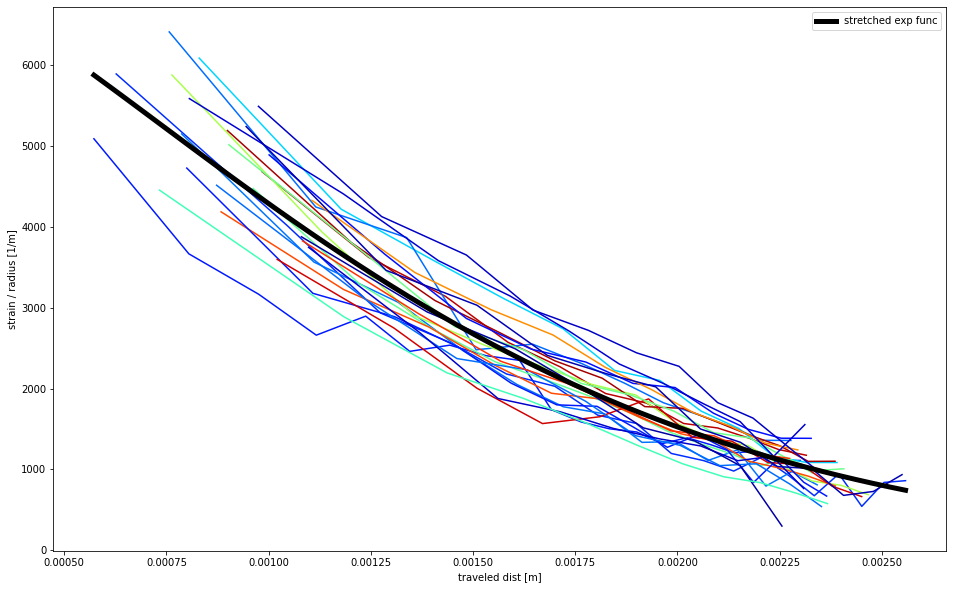

In [42]:
def linear(x,m,t):
    return x*m+t
def exp_stretched(t,a,tau,beta):
    return a*np.exp(-(t/tau)**beta)

#lowest and highest radius in detected objects
min_r = np.min(traj['radius_m'])
max_r = np.max(traj['radius_m'])

#choose colormap
cmap = plt.get_cmap('jet')

fig,ax = plt.subplots(figsize=(16,10))

for par,d in traj.groupby('particle'):
    r = np.mean(d['radius_m'])
    color = int((r-min_r)/(max_r-min_r)*255)
    c = cmap(color)
    
    #ax.plot(d['traveled_dist'],d['strain'],color=c)
    #curves collapse if divided by radius
    ax.plot(d['traveled_dist_m'],d['strain']/d['radius_m'],color=c)

    
    ax.set_xlabel('traveled dist [m]')
    ax.set_ylabel('strain / radius [1/m]')
    
    #plt.semilogx()

#save traj data frame to csv file
#traj.to_csv(r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\traj.csv')

#fit strechted exp function to data
popt_m,pcov = curve_fit(exp_stretched,traj['traveled_dist_m'],traj['strain']/traj['radius_m'],p0=[0.05,1e-3,0.4])
print(popt_m)
x_ = np.linspace(np.min(traj['traveled_dist_m']),np.max(traj['traveled_dist_m']))
plt.plot(x_,exp_stretched(x_,*popt_m),linewidth=5,color='black',label='stretched exp func')
plt.legend()
plt.show()

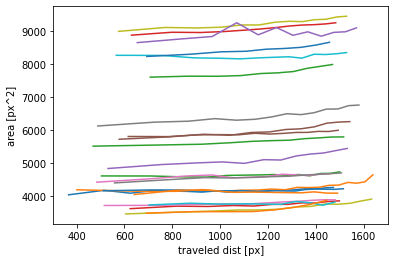

In [43]:
#check if area of ellipsoids stays constant
for par,d in traj.groupby('particle'):
    plt.plot(d['traveled_dist'],d['area_el'])
    #plt.plot(d['traveled_dist'],d['area_poly'])
    plt.xlabel('traveled dist [px]')
    plt.ylabel('area [px^2]')
plt.show()

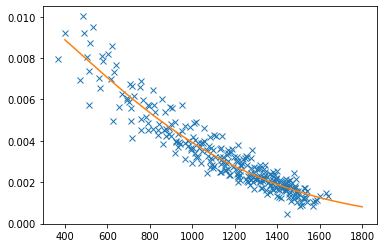

In [44]:
x_ = np.linspace(400,1800)


plt.plot(traj['traveled_dist'],traj['strain']/traj['radius'],'x')

popt,pcov = curve_fit(exp_stretched,traj['traveled_dist'],traj['strain']/traj['radius'],p0=[0.05,100,0.4])
x_ = np.linspace(400,1800)
plt.plot(x_,exp_stretched(x_,*popt))
plt.show()

(1920.0, 0.0)

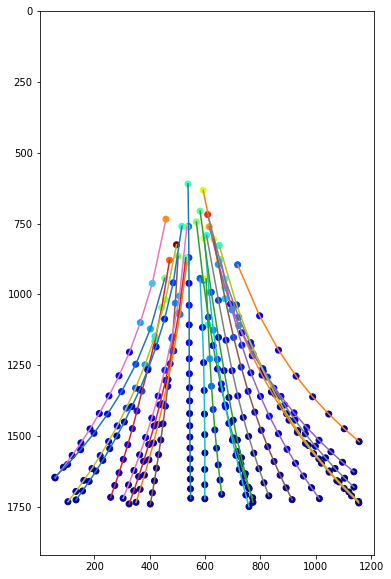

In [45]:
def linear_map(x,a,b,c,d):
    #map from interval [a,b] to interval [c,d]
    return c + ((d-c)/(b-a))*(x-a)


max_c = np.max(traj['guck_def'])
min_c = np.min(traj['guck_def'])

fig,ax = plt.subplots(figsize=(6,10))
for par,d in traj.groupby('particle'):
    c = linear_map(d['guck_def'],min_c,max_c,0,255)
    c = c.astype(int)
    c = cmap(c)
    ax.scatter(d['x'],d['y'],color=c)
    ax.plot(d['x'],d['y'])
ax.set_ylim(1920,0)

0.07183764036466025 N/m


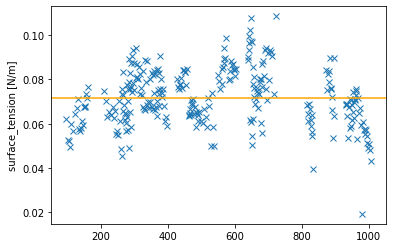

In [46]:
#calculate surface tension of spheroids
a,tau,beta = popt_m
gamma_s = traj['strain']/(traj['radius_m']*a/(72e-3)) * 1/(np.exp(-(traj['traveled_dist_m']/tau)**beta))

def const(x,a):
    return a

popt,pcov = curve_fit(const,np.arange(len(gamma_s)),gamma_s)
plt.plot(gamma_s,'x')
plt.ylabel('surface_tension [N/m]')
plt.axhline(popt,color='orange')
print(popt[0],'N/m')

# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
e
# duration of the video
#duration = 30

duration = len(series)/10
 
# matplot subplot
fig, ax = plt.subplots(figsize=(16,10))
 
# method to get frames
def make_frame(t):
    # clear
    ax.clear()
    t_ = int(10*t)
    # plotting line
    ax.imshow(series[t_])
    m = traj['frame'] == t_
    '''
    ells = traj[m]
    for index, row in ells.iterrows():
        e = Ellipse(xy=(row['x'],row['y']),width=row['l'], height=row['s'],angle=row['angle'])
        ax.add_artist(e)
        e.set_facecolor("none")
        e.set_edgecolor("red")
    ''' 
    # returning numpy image
    return mplfig_to_npimage(fig)
 
# creating animation
animation = VideoClip(make_frame, duration = duration)
 
# displaying animation with auto play and looping
#animation.ipython_display(fps = 20, loop = True, autoplay = True)
animation.write_videofile(output_path, fps=15) 

In [62]:
path_to_tif_s = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\new_camera\2022_07_01_15_55_32.tif' #one spheroid p=50Pa
series_s = load_tif(path_to_tif_s)
print(series_s.shape)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:09<00:00, 275.94it/s]


(2500, 640, 480)


In [63]:
df_s = find_objs(series_s)
traj_s = link(df_s)
traj_s = add_properties(traj_s)
#traj_s = filter_traj(traj_s,min_det=3,y0_min=90,y0_max=400,y_last=400,area_tol=0.5,y_max=600,area_max=np.inf)
traj_s = traj_s[traj_s['y']<600]

Frame 2136: 1 trajectories present.


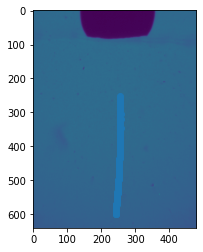

In [64]:
plt.imshow(series_s[0])
plt.scatter(traj_s['x'],traj_s['y'])

(0.0, 0.4)

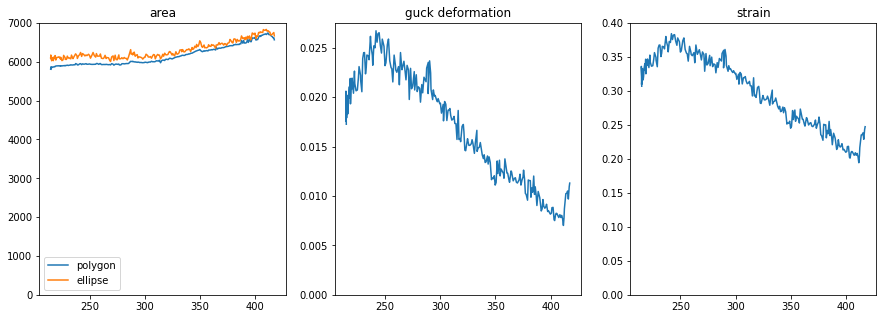

In [65]:
fig,axs = plt.subplots(ncols=3,figsize=(15,5))
axs[0].plot(traj_s['traveled_dist'],traj_s['area_poly'],label='polygon')
axs[0].plot(traj_s['traveled_dist'],traj_s['area_el'],label='ellipse')
axs[0].set_title('area')
axs[0].set_ylim(0,7000)
axs[0].legend()

axs[1].plot(traj_s['traveled_dist'],traj_s['guck_def'])
axs[1].set_title('guck deformation')
axs[1].set_ylim(0,0.0275)

axs[2].plot(traj_s['traveled_dist'],traj_s['strain'])
axs[2].set_title('strain')
axs[2].set_ylim(0,0.4)

# create video

# TODO
- overlapping bubbles or objects DONE filter them by checking area
- debris? DONE
- deformability over distance traveled DONE
- deformability over size (of bubbles) DONE
- strain of spheroids using polygons

In [ ]:
directory = r'\\131.188.117.96\biophysDS2\jbartl\Spheriod_data\01_07_22\1000_cell'
files = []
for file in os.listdir(directory):
    if file.endswith(".tif"):
        files.append(os.path.join(directory, file))
print(files[3])
# remove 2
series_s = load_tif(files[3])

df_s = find_objs(series_s)
print(df_s)
traj_s = link(df_s)
traj_s = add_properties(traj_s)
#traj_s = filter_traj(traj_s,min_det=3,y0_min=90,y0_max=400,y_last=400,area_tol=0.5,y_max=600,area_max=np.inf)
traj_s = traj_s[traj_s['y']<600]
plt.imshow(series_s[0])
plt.scatter(traj_s['x'],traj_s['y'])
plt.show()

fig,axs = plt.subplots(ncols=3,figsize=(15,5))
axs[0].plot(traj_s['traveled_dist'],traj_s['area_poly'],label='polygon')
axs[0].plot(traj_s['traveled_dist'],traj_s['area_el'],label='ellipse')
axs[0].set_title('area')
#axs[0].set_ylim(0,7000)
axs[0].legend()

axs[1].plot(traj_s['traveled_dist'],traj_s['guck_def'])
axs[1].set_title('guck deformation')
#axs[1].set_ylim(0,0.0275)

axs[2].plot(traj_s['traveled_dist'],traj_s['strain'])
axs[2].set_title('strain')
#axs[2].set_ylim(0,0.4)
